# Data Retrieval - Climate data

## WorldClim Data

In [6]:
!export LATLONDATA=$Users/davidschildberger/03_LeWagon_Datasets/WorldClim/wc2_tavg_10m

In [10]:
!pip install xarray
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.9/30.9 MB 4.9 MB/s eta 0:00:0000:0100:01
  Using cached click-8.1.3-py3-none-any.whl (96 kB)


In [3]:
from latlon_utils import get_climate

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio

In [11]:
get_climate(50, 10)

Extracting /var/folders/jj/6lhmrlt15xs297nzzcs7734w0000gn/T/worldclim_psugasm7/wc2.1_10m_tavg.zip
Saving as netcdf file to /Users/davidschildberger/.local/share/latlon_utils/tavg_10m.nc


/Users/davidschildberger/.pyenv/versions/3.10.6/envs/planetary_garden/lib/python3.10/site-packages/netCDF4/utils.py:76: RuntimeWarning: overflow encountered in multiply
  datout = np.around(scale*data)/scale


Extracting /var/folders/jj/6lhmrlt15xs297nzzcs7734w0000gn/T/worldclim_2bwagfw6/wc2.1_10m_prec.zip
Saving as netcdf file to /Users/davidschildberger/.local/share/latlon_utils/prec_10m.nc


tavg  jan     0.053223
      feb     0.958252
      mar     4.760742
      apr     8.333008
      mai    13.220520
      jun    16.089722
      jul    17.987976
      aug    17.847229
      sep    13.790222
      oct     8.807007
      nov     4.054260
      dec     1.496521
      djf     0.835999
      mam     8.771423
      jja    17.308309
      son     8.883830
      ann     8.949890
prec  jan    48.000000
      feb    42.000000
      mar    44.000000
      apr    44.000000
      mai    56.000000
      jun    68.000000
      jul    65.000000
      aug    52.000000
      sep    47.000000
      oct    52.000000
      nov    52.000000
      dec    59.000000
      djf    49.666667
      mam    48.000000
      jja    61.666667
      son    50.333333
      ann    52.416667
Name: (50, 10), dtype: float64

In [277]:
pathf = '/Users/davidschildberger/03_LeWagon_Datasets/WorldClim/wc2_bio/wc2.1_10m_bio_1.tif'

In [279]:
dataset = rasterio.open(pathf)

In [280]:
dataset.width

2160

In [281]:
dataset.height

1080

In [282]:
dataset.bounds

BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)

In [290]:
dataset.read(1).shape

(1080, 2160)

## CRU Data

In [13]:
import gzip
import os
import shutil
import tempfile
import netCDF4
from netCDF4 import Dataset
import numpy as np
import pandas as pd

In [194]:
lon = 16.363449
lat = 48.210033

In [ ]:
val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']

In [230]:
def get_filename(feat_name):
    fold_n = '/Users/davidschildberger/03_LeWagon_Datasets/CRU_raw_data/'
    fi_n = os.listdir(fold_n)
    fi_n.remove('.DS_Store')
    for i in fi_n: 
        if(feat_name in i) : 
            return i

In [ ]:
def open_netcdf(fname):
    with gzip.open((fold_n+fname), 'rb') as f:
        tmp = tempfile.NamedTemporaryFile(delete=False)
        shutil.copyfileobj(f, tmp)

        f.close()
        tmp.close()
        
        data = netCDF4.Dataset(tmp.name)
        os.unlink(tmp.name)
    return data

In [259]:
def retrieve_CRU_data(datatype, year, lon, lat):
    
    data = open_netcdf(get_filename(datatype)) # 0 = 'cld'
    
    year_in_month = (year-1901)*12
    
    c_lat = int(round(np.interp(lat, [-90, 90], [0, 360])))  # check order of values here
    c_lon = int(round(np.interp(lon, [-180, 180], [0, 720])))
    
    temp_dat_date = data.variables[datatype][year_in_month:year_in_month+12,c_lat,c_lon].data
    return temp_dat_date

In [262]:
sp_dat = retrieve_CRU_data('cld', 1980, lon, lat)
sp_dat, sp_dat.mean()

(array([76.700005, 73.200005, 72.8     , 67.9     , 54.600002, 67.5     ,
        67.8     , 53.3     , 59.8     , 68.700005, 75.8     , 72.3     ],
       dtype=float32),
 67.53333)

In [439]:
def retrieve_all_features_mean_CRU_data(year, lon, lat):
    val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
    mean_val = []
    for val in val_nam_list:
        mean_val.append(retrieve_CRU_data(val, year, lon, lat).mean())
    return dict(zip(val_nam_list, mean_val))

In [440]:
retrieve_all_features_mean_CRU_data(1980, lon, lat)

{'cld': 67.53333,
 'dtr': 7.6083336,
 'frs': 9.624166,
 'pet': 1.9583334,
 'pre': 49.899998,
 'tmn': 5.066667,
 'tmp': 8.841666,
 'tmx': 12.675,
 'vap': 9.216666,
 'wet': 12.561666}

### Bio Variables / slow?!

In [295]:
## BIO1 = Annual Mean Temperature
def bio_1_annual_mean_temp(year, lon, lat):
    temp_mean = 'tmp'
    return retrieve_CRU_data(temp_mean, year, lon, lat).mean()

In [296]:
bio_1_annual_mean_temp(1980, lon, lat)

8.841666

In [298]:
## Mean Diurnal Range (Mean of monthly (max temp - min temp))
def bio_2_mean_diurnal_range(year, lon, lat):
    t_min = retrieve_CRU_data('tmn', year, lon, lat)
    t_max = retrieve_CRU_data('tmx', year, lon, lat)
    diurnal = t_max-t_min
    return diurnal.mean()

In [299]:
bio_2_mean_diurnal_range(1980, lon, lat)

7.6083336

In [402]:
## BIO3 = Isothermality (BIO2/BIO7) (×100)
def bio_3_isothermality(year, lon, lat):
    val = bio_2_mean_diurnal_range(year, lon, lat)/bio_7_temp_range(year, lon, lat)
    return val

In [403]:
bio_3_isothermality(1980, lon, lat)

0.24863835

In [311]:
## BIO4 = Temperature Seasonality (standard deviation ×100)
def bio_4_temperature_seasonality(year, lon, lat):
    t_mean = retrieve_CRU_data('tmp', year, lon, lat)
    return np.std(t_mean)

In [312]:
bio_4_temperature_seasonality(1980, lon, lat)

7.3900223

In [314]:
## BIO5 = Max Temperature of Warmest Month
def bio_5_max_temp_of_max_month(year, lon, lat):
    t_max = retrieve_CRU_data('tmx', year, lon, lat)
    return np.max(t_max)

In [316]:
bio_5_max_temp_of_max_month(1980, lon, lat)

24.9

In [328]:
## BIO6 = Min Temperature of Coldest Month
def bio_6_min_temp_of_min_month(year, lon, lat):
    t_min = retrieve_CRU_data('tmn', year, lon, lat)
    return np.min(t_min)

In [329]:
bio_6_min_temp_of_min_month(1980, lon, lat)

-5.7000003

In [330]:
## BIO7 = Temperature Annual Range (BIO5-BIO6)
def bio_7_temp_range(year, lon, lat):
    rang_temp = bio_5_max_temp_of_max_month(year, lon, lat)-bio_6_min_temp_of_min_month(year, lon, lat)
    return rang_temp

In [331]:
bio_7_temp_range(1980, lon, lat)

30.6

In [351]:
## BIO8 = Mean Temperature of Wettest Quarter
def bio_8_mean_temp_wet_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('tmp', year, lon, lat)[st:st+3].mean()

In [352]:
bio_8_mean_temp_wet_q(1980, lon, lat)

4.1666665

In [353]:
## BIO9 = Mean Temperature of Driest Quarter
def bio_9_mean_temp_dry_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return retrieve_CRU_data('tmp', year, lon, lat)[st:st+3].mean()

In [354]:
bio_9_mean_temp_dry_q(1980, lon, lat)

17.7

In [340]:
## BIO10 = Mean Temperature of Warmest Quarter
def bio_10_mean_temp_warm_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return temp_wet[st:st+3].mean()

In [341]:
bio_10_mean_temp_warm_q(1980, lon, lat)

17.7

In [343]:
## BIO11 = Mean Temperature of Coldest Quarter
def bio_11_mean_temp_cold_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return temp_wet[st:st+3].mean()

In [344]:
bio_11_mean_temp_cold_q(1980, lon, lat)

1.1

In [349]:
## BIO12 = Annual Precipitation
def bio_12_annual_prec(year, lon, lat):
    return retrieve_CRU_data('pre', year, lon, lat).sum()

In [350]:
bio_12_annual_prec(1980, lon, lat)

598.8

In [361]:
## BIO13 = Precipitation of Wettest Month
def bio_13_prec_wet_mo(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    max_index=np.argmax(temp_wet)
    return retrieve_CRU_data('pre', year, lon, lat)[max_index]

In [362]:
bio_13_prec_wet_mo(1980, lon, lat)

75.1

In [363]:
## BIO14 = Precipitation of Driest Month
def bio_14_prec_dry_mo(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    min_index=np.argmin(temp_wet)
    return retrieve_CRU_data('pre', year, lon, lat)[min_index]

In [364]:
bio_14_prec_dry_mo(1980, lon, lat)

34.7

In [375]:
## BIO15 = Precipitation Seasonality (Coefficient of Variation)
def bio_15_prec_wet_mo(year, lon, lat):
    temp_pre = retrieve_CRU_data('pre', year, lon, lat)
    cv = lambda x: np.std(temp_pre, ddof=1) / np.mean(temp_pre) * 100
    return cv(temp_pre)

In [376]:
bio_15_prec_wet_mo(1980, lon, lat)

46.613526344299316

In [405]:
## BIO16 = Precipitation of Wettest Quarter
def bio_16_pre_wet_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [406]:
bio_16_pre_wet_q(1980, lon, lat)

57.333332

In [385]:
## BIO17 = Precipitation of Driest Quarter
def bio_17_pre_dry_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [386]:
bio_17_pre_dry_q(1980, lon, lat)

47.766666

In [387]:
## BIO18  Precipitation of Warmest Quarter...
def bio_18_pre_dry_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [388]:
bio_18_pre_dry_q(1980, lon, lat)

47.766666

In [419]:
## BIO19 = Precipitation of Coldest Quarter...
def bio_19_pre_cld_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [420]:
bio_19_pre_cld_q(1980, lon, lat)

28.200003

In [421]:
def get_bioclim_var(year, lon, lat):
    temp_li = []
    temp_li.append(bio_1_annual_mean_temp(year, lon, lat))
    temp_li.append(bio_2_mean_diurnal_range(year, lon, lat))
    temp_li.append(bio_3_isothermality(year, lon, lat))
    temp_li.append(bio_4_temperature_seasonality(year, lon, lat))
    temp_li.append(bio_5_max_temp_of_max_month(year, lon, lat))
    temp_li.append(bio_6_min_temp_of_min_month(year, lon, lat))
    temp_li.append(bio_7_temp_range(year, lon, lat))
    temp_li.append(bio_8_mean_temp_wet_q(year, lon, lat))
    temp_li.append(bio_9_mean_temp_dry_q(year, lon, lat))
    temp_li.append(bio_10_mean_temp_warm_q(year, lon, lat))
    temp_li.append(bio_11_mean_temp_cold_q(year, lon, lat))
    temp_li.append(bio_12_annual_prec(year, lon, lat))
    temp_li.append(bio_13_prec_wet_mo(year, lon, lat))
    temp_li.append(bio_14_prec_dry_mo(year, lon, lat))
    temp_li.append(bio_15_prec_wet_mo(year, lon, lat))
    temp_li.append(bio_16_pre_wet_q(year, lon, lat))
    temp_li.append(bio_17_pre_dry_q(year, lon, lat))
    temp_li.append(bio_18_pre_cld_q(year, lon, lat))
    temp_li.append(bio_19_pre_cld_q(year, lon, lat))
    return temp_li

In [422]:
get_bioclim_var(1980, lon, lat)

[8.841666,
 7.6083336,
 0.24863835,
 7.3900223,
 24.9,
 -5.7000003,
 30.6,
 4.1666665,
 17.7,
 17.7,
 1.1,
 598.8,
 75.1,
 34.7,
 46.613526344299316,
 57.333332,
 47.766666,
 28.200003,
 28.200003]

### Bio variables / optimized

In [ ]:
def retrieve_CRU_data_all(datatype, year):
    data = open_netcdf(get_filename(datatype))
    return data.variables[datatype][year_in_month:year_in_month+12,:,:].data

In [424]:
dat_t = retrieve_CRU_data_all('cld', 1980)
dat_t.shape

(12, 360, 720)

In [436]:
def retrieve_all_features_CRU_data(year):
    val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
    val_t = []
    for val in val_nam_list:
        val_t.append(retrieve_CRU_data_all(val, year))
    return np.array(val_t)

In [437]:
dat_ = retrieve_all_features_mean_CRU_data(1980)
dat_

array([[[[9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         ...,
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36]],

        [[9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         ...,
         [9.96921e+36, 9.96921e+36

In [438]:
dat_.shape

(10, 12, 360, 720)

In [448]:
def retrieve_all_features_all_years_CRU_data(year_start, year_stop):
    val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
    
    year_start_in_month = (year_start-1901)*12
    year_stop_in_month = (year_stop-1901)*12
    
    val_t = []
    for val in val_nam_list:
        data = open_netcdf(get_filename(val))
        val_t.append(data.variables[val][year_start_in_month:year_stop_in_month,:,:].data)
    return np.array(val_t)

In [451]:
dt = retrieve_all_features_all_years_CRU_data(1980,1982)
dt.shape

(10, 24, 360, 720)

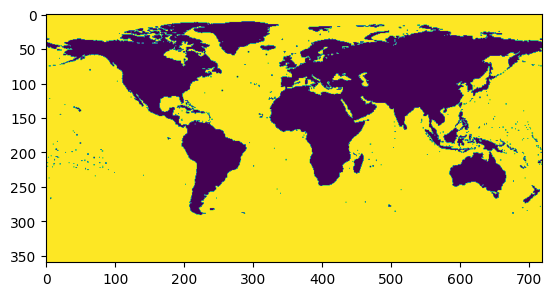

In [515]:
plt.imshow(np.flip(dt[0,0,:,:],0));

In [624]:
## BIO1 = Annual Mean Temperature
def bio_1(year):
    val = 'tmp'
    data = open_netcdf(get_filename(val))
    
    year_in_month = (year-1901)*12
    
    d = data.variables[val][year_in_month:year_in_month+12,:,:].data.mean(axis=0)
    d[d > 255] = np.nan
    return d

In [625]:
b1 = bio_1(1980)
b1.shape

(360, 720)

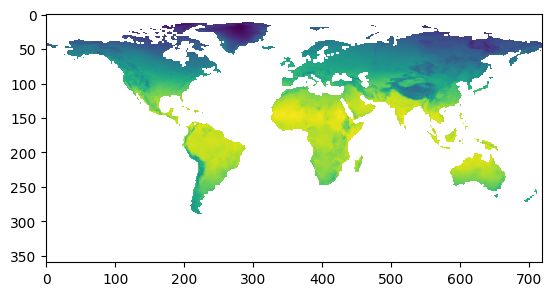

In [626]:
plt.imshow(np.flip(b1,0));

In [687]:
## Mean Diurnal Range (Mean of monthly (max temp - min temp))
def bio_2(year):
    data_tmn = open_netcdf(get_filename('tmn'))
    data_tmx = open_netcdf(get_filename('tmx'))
    year_in_month = (year-1901)*12
    
    t_min = data_tmn.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    t_max = data_tmx.variables['tmx'][year_in_month:year_in_month+12,:,:].data
    t_min[t_min > 255] = np.nan
    t_max[t_max > 255] = np.nan
    d = t_max - t_min
    return d.mean(axis=0)

In [688]:
b2 = bio_2(1980)

In [689]:
b2.shape

(360, 720)

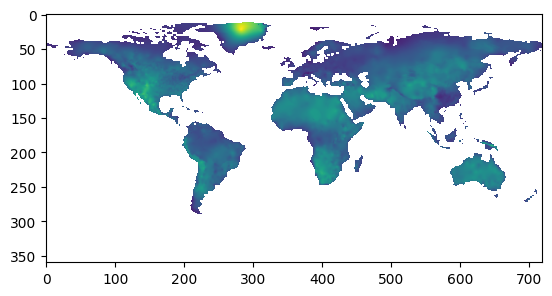

In [690]:
plt.imshow(np.flip(b2,0));

In [664]:
## BIO3 = Isothermality (BIO2/BIO7) (×100)
def bio_3(year):
    val = bio_2(year)/bio_7(year)
    val[val > 255] = np.nan
    return val

In [665]:
b3 = bio_3(1980)

In [666]:
b3.shape

(360, 720)

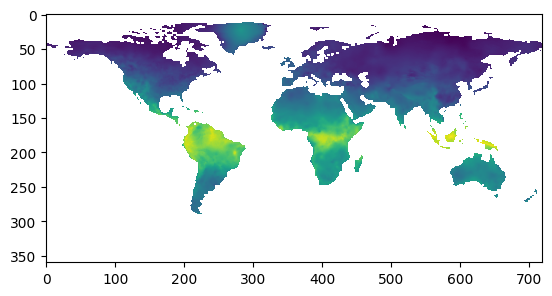

In [667]:
plt.imshow(np.flip(b3,0));

In [672]:
## BIO4 = Temperature Seasonality (standard deviation ×100)
def bio_4(year):
    data = open_netcdf(get_filename('tmp'))

    year_in_month = (year-1901)*12
    
    t_mp = data.variables['tmp'][year_in_month:year_in_month+12,:,:].data
    t_mp[t_mp > 255] = np.nan
    return np.std(t_mp, axis=0)

In [673]:
b4 = bio_4(1980)

In [674]:
b4.shape

(360, 720)

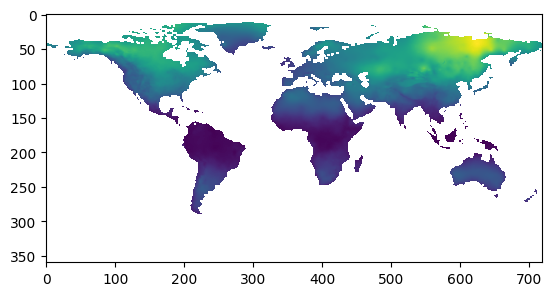

In [675]:
plt.imshow(np.flip(b4,0));

In [646]:
## BIO5 = Max Temperature of Warmest Month
def bio_5(year):
    data = open_netcdf(get_filename('tmx'))

    year_in_month = (year-1901)*12
    
    t_max = data.variables['tmx'][year_in_month:year_in_month+12,:,:].data
    t_max[t_max > 255] = np.nan
    return np.max(t_max, axis=0)

In [647]:
b5 = bio_5(1980)

In [648]:
b5.shape

(360, 720)

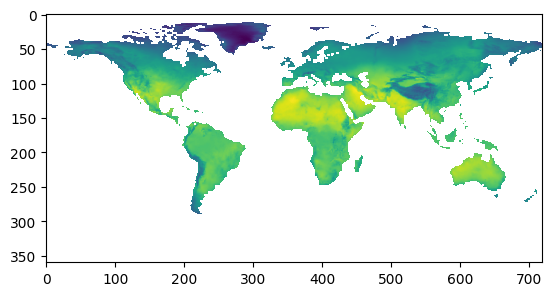

In [649]:
plt.imshow(np.flip(b5,0));

In [653]:
## BIO6 = Min Temperature of Coldest Month
def bio_6(year):
    data = open_netcdf(get_filename('tmn'))

    year_in_month = (year-1901)*12
    
    t_min = data.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    t_min[t_min > 255] = np.nan
    return np.min(t_min, axis=0)

In [654]:
b6 = bio_6(1980)

In [655]:
b6.shape

(360, 720)

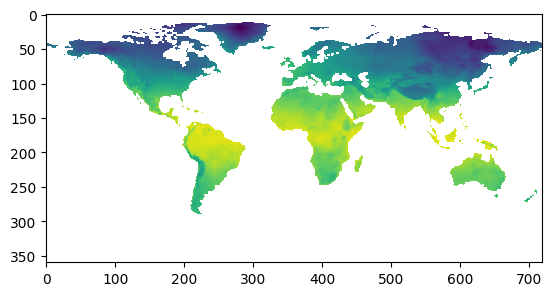

In [656]:
plt.imshow(np.flip(b6,0));

In [668]:
## BIO7 = Temperature Annual Range (BIO5-BIO6)
def bio_7(year):
    rang_temp = bio_5(1980)-bio_6(1980)
    rang_temp[rang_temp > 255] = np.nan
    return rang_temp

In [669]:
b7 = bio_7(1980)

In [670]:
b7.shape

(360, 720)

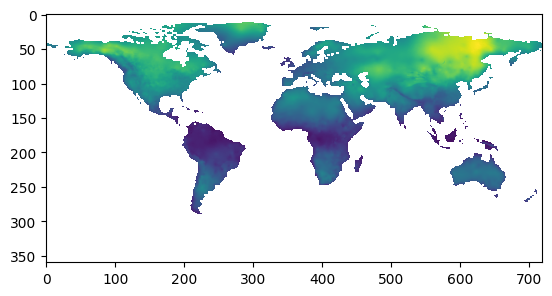

In [671]:
plt.imshow(np.flip(b7,0));

In [ ]:
## BIO8 = Mean Temperature of Wettest Quarter
def bio_8(year):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('tmp', year, lon, lat)[st:st+3].mean()

In [ ]:
## BIO8 = Mean Temperature of Wettest Quarter
def bio_8(year):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('tmp', year, lon, lat)[st:st+3].mean()